In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Clustering de voitures

Nous souhaitons diviser des voitures en plusieurs groupes. Commençons par regarder les données : 

In [40]:
import pandas as pd

data = pd.read_excel("voitures_clustering.xlsx")
data

,Modele,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,PANDA,54,1108,150,354,159,154,860,135
1,TWINGO,60,1149,151,344,163,143,840,143
2,YARIS,65,998,155,364,166,150,880,134
3,CITRONC2,61,1124,158,367,166,147,932,141
4,CORSA,70,1248,165,384,165,144,1035,127
5,FIESTA,68,1399,164,392,168,144,1138,117
6,CLIO,100,1461,185,382,164,142,980,113
7,P1007,75,1360,165,374,169,161,1181,153
8,MODUS,113,1598,188,380,170,159,1170,163
9,MUSA,100,1910,179,399,170,169,1275,146


L'histogramme de chaque paramètre donne des indications sur sa répartition :

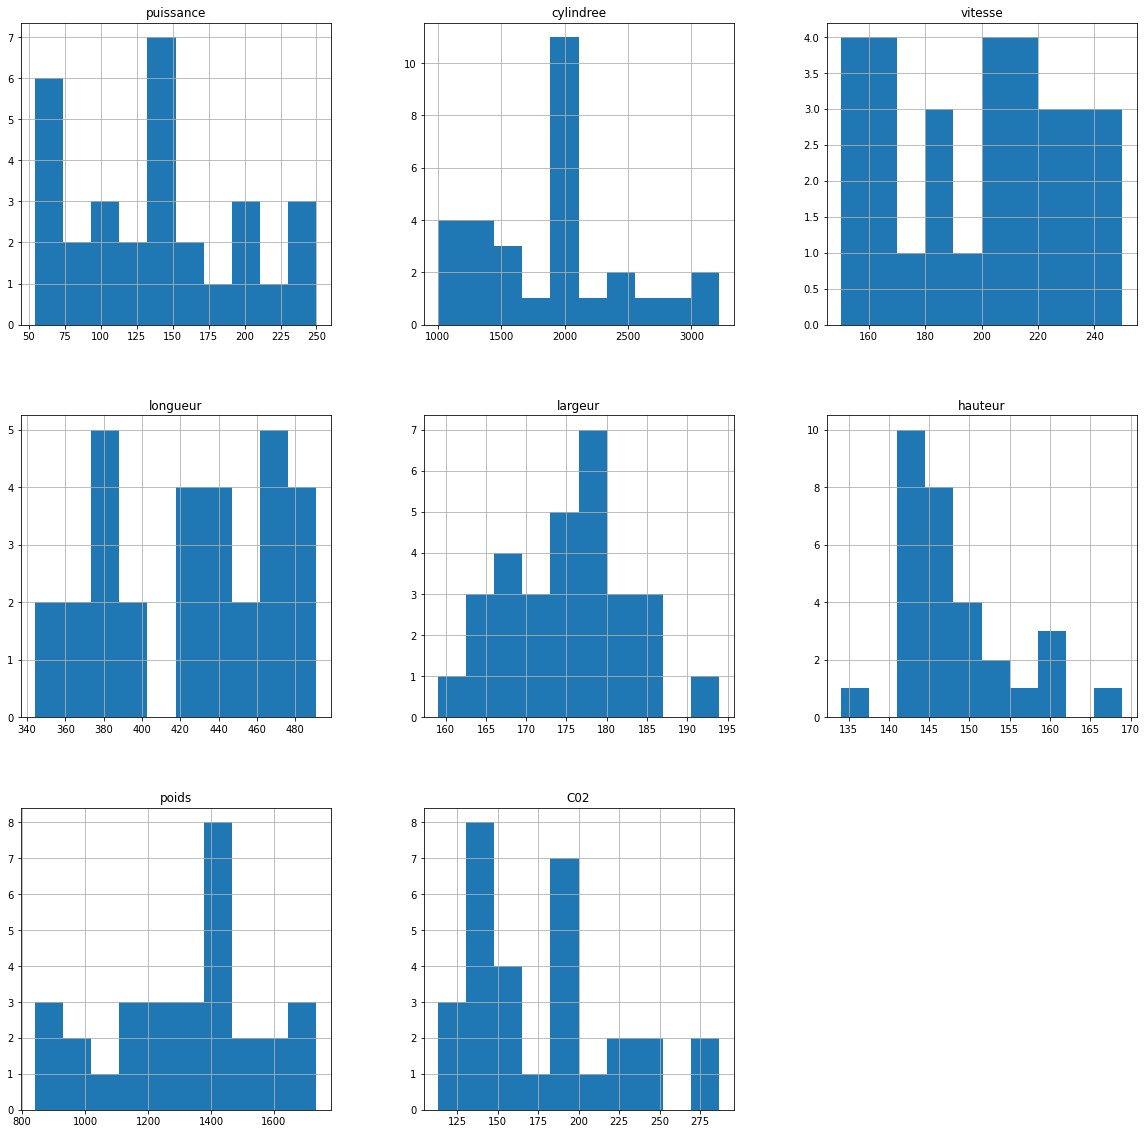

In [41]:
data.hist(bins=10, figsize=(20, 20));

Pour utiliser un algorithme de machine learning, il est toujours conseillé de standardiser les données.

In [42]:
from sklearn import preprocessing

data_scaled = preprocessing.scale(data.iloc[:, 1:])  # standardisation

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data2d = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_
pd.DataFrame(pca.components_, columns=data.columns[1:])

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,-0.393466,-0.364012,-0.400973,-0.386224,-0.348839,0.120983,-0.384690,-0.344120
1,-0.099743,0.240731,-0.113762,0.060612,0.153163,0.868122,0.282546,-0.241984


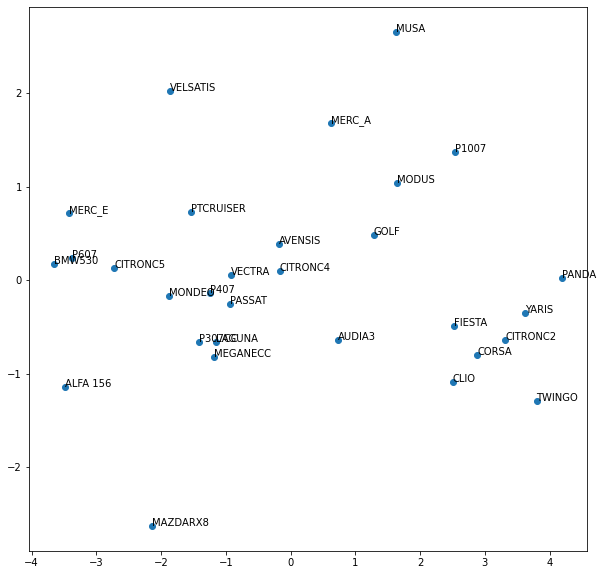

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data2d[:, 0], data2d[:, 1], );
for i, p in enumerate(data2d):
    ax.annotate(data.loc[i, "Modele"], p)

Puisque nous ne connaissons pas à l'avance les labels/groupes, nous allons utiliser un algorithme de clustering. L'un des plus connus est K-Means.  
Comme le nombre de clusters $k$ est inconnu, nous allons appliquer l'algorithme K-Means (en fait K-Means++, qui )

In [49]:
silhouette_score

NameError: name 'silhouette_score' is not defined

In [ ]:
def kmeans_avg(data, k):
    

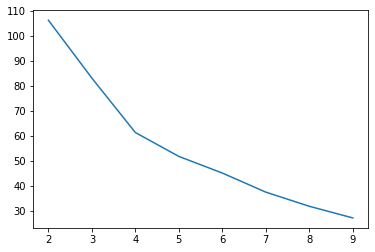

In [20]:
from sklearn.cluster import KMeans

X, Y = [], []
for i in range(2, 10):
    km = KMeans(n_clusters=i).fit(data_scaled)
    Y.append(km.inertia_)
    X.append(i)
plt.plot(X, Y)
plt.show()

In [14]:
km = KMeans(n_clusters=4).fit(data_scaled)

In [18]:
from sklearn.linear_model import LogisticRegression

dt = data.iloc[:, 1:]

for i in range(km.n_clusters):
    t = np.where(km.labels_ == i)[0]
    y = np.zeros((len(data.index)))
    y[t] = 1
    lr = LogisticRegression(max_iter = 4000).fit(dt, y)
    pd = pandas.DataFrame(np.array([np.mean(data.loc[t]), lr.coef_[0]]).T, index = dt.columns, columns = ["Moyenne", "Coeffs"])
    print(pd)

               Moyenne    Coeffs
puissance    68.285714 -0.071782
cylindree  1212.428571 -0.018595
vitesse     161.142857  0.052172
longueur    369.571429  0.188986
largeur     164.428571  0.079396
hauteur     146.285714  0.041197
poids       952.142857 -0.038762
C02         130.000000 -0.186173
               Moyenne    Coeffs
puissance   145.090909 -0.435008
cylindree  1950.454545 -0.019804
vitesse     210.909091  0.710963
longueur    454.363636  0.262498
largeur     180.000000 -0.482883
hauteur     145.727273 -0.859915
poids      1411.545455  0.045929
C02         180.818182 -0.074443
           Moyenne    Coeffs
puissance    100.6 -0.368794
cylindree   1765.4  0.023960
vitesse      179.2 -0.007900
longueur     391.6 -0.514661
largeur      172.4  0.203545
hauteur      159.6  0.417526
poids       1236.6  0.073590
C02          149.2  0.099268
               Moyenne    Coeffs
puissance   221.857143  0.183798
cylindree  2619.142857  0.019029
vitesse     234.000000 -0.084655
longueur    4

/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/qfortier/.cache/pypoetry/virtualenvs/notebook-Otwu4MGz-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'nu